In [ ]:
# !!!:
# Switch to wards
# Distribute population eqaully over the hexes
# Add scatterplot

# Exploratory data analysis

We started our journey with a hypothesis: "_there should be some connection between amenities and traffic!_". Indeed, as a citizen, you wake up, drink a cup of coffee, go to work. During the day you eat lunch, do shopping, gym etcetera. So, there is a reason for you to leave home, right? And to get to so called a place of interest (POI) you use a certain mode of transport. Let us imagine that there is a single way to travel in the city: metro. With this notebook, we are going to explore what are the __relationships between amenities__ and the __underground traffic__.

One of the critical aspect of this study is the choice of "the right" resolution or the area to analyze. The options are: 
* operate with official statistical boundaries (boroughs and wards);
* crete a custom hexgrid;
* use Voronoi tesselation.

The are pros and cons of using each of these options. By using official statistical boundaries we are ensuring that the numbers are "correct". For examplee, population of a borough is 5000 citizens. However, we also know that population and amenities are not equally distributed over a borough. People and business are "conneted" to buildings.     

We will start our analysis by exploring whether or not amenities and population are "correlated." Secondly, we will cluster amenities into groups and compare these groups with the clusters of Verma et al. (2020). In this work, authors 

In [123]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tobler.area_weighted import *
import tobler

from scipy import spatial
from shapely.geometry import Point, Polygon, box, shape

# Load user-defined functions
from src.create_hexgrid import create_hexgrid
from src.vizualization import scatterplot, choropleth # , plot_hexgrid

plt.style.use('seaborn')

## 1. Amenities and population

In [61]:
# Load the data
population = gpd.read_file('../data/processed/population/boroughs.json')

# Keep only the columns of interest
population = population[['LAD11NM', 'total_population', 'adult_population', 'geometry']]

# Change index to make merge easier
population.set_index('LAD11NM', inplace=True)

pois = pd.read_csv('../data/processed/pois/pois.csv', low_memory=False)
pois = gpd.GeoDataFrame(pois, geometry=gpd.points_from_xy(pois['lon'], pois['lat']))
pois.crs = {'init' : 'epsg:4326'}
pois_categories = pd.read_csv("../data/external/pois_categories.csv")

### Municipal boundaries

In [41]:
# Load the data
pois_counts_boroughs = pd.read_csv('../data/processed/pois/pois_counts_boroughs.csv')

# Change index to make merge easier
pois_counts_boroughs.set_index('pois_category', inplace=True)

# Let's combine population and pois counts
df = pd.concat([pois_counts_boroughs, population.T])
df.fillna(0, inplace=True)

# Prepare a GeoDataFrame
gdf = gpd.GeoDataFrame(df.T, geometry='geometry')
gdf.crs = population.crs
gdf.to_crs(epsg=3857, inplace=True)

# Make sure that all values are numeric
gdf.loc[:,:'adult_population'] = gdf.loc[:,:'adult_population'].apply(pd.to_numeric)

Can we find a pattern between the number of amenties by type and population?

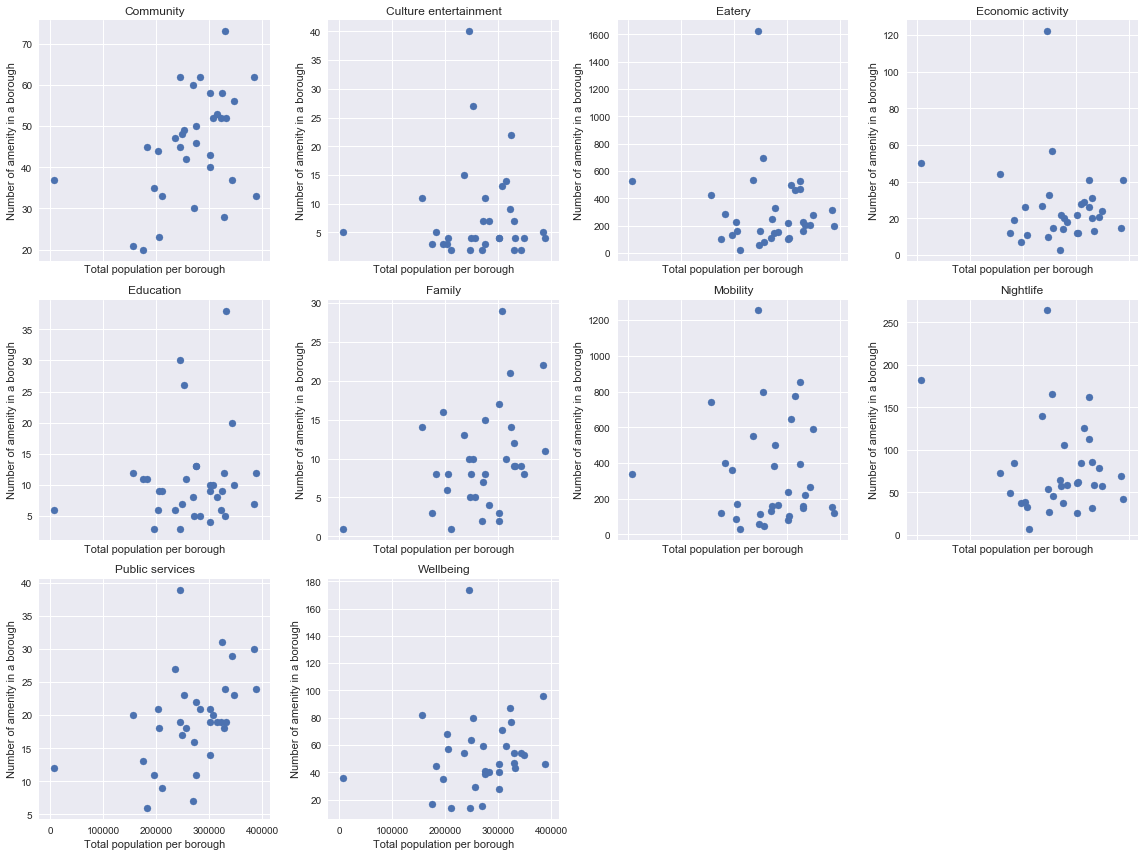

In [3]:
scatterplot(df)

What about the map? Can we find some explainable patterns if visualize the distribution of amenities geographically?

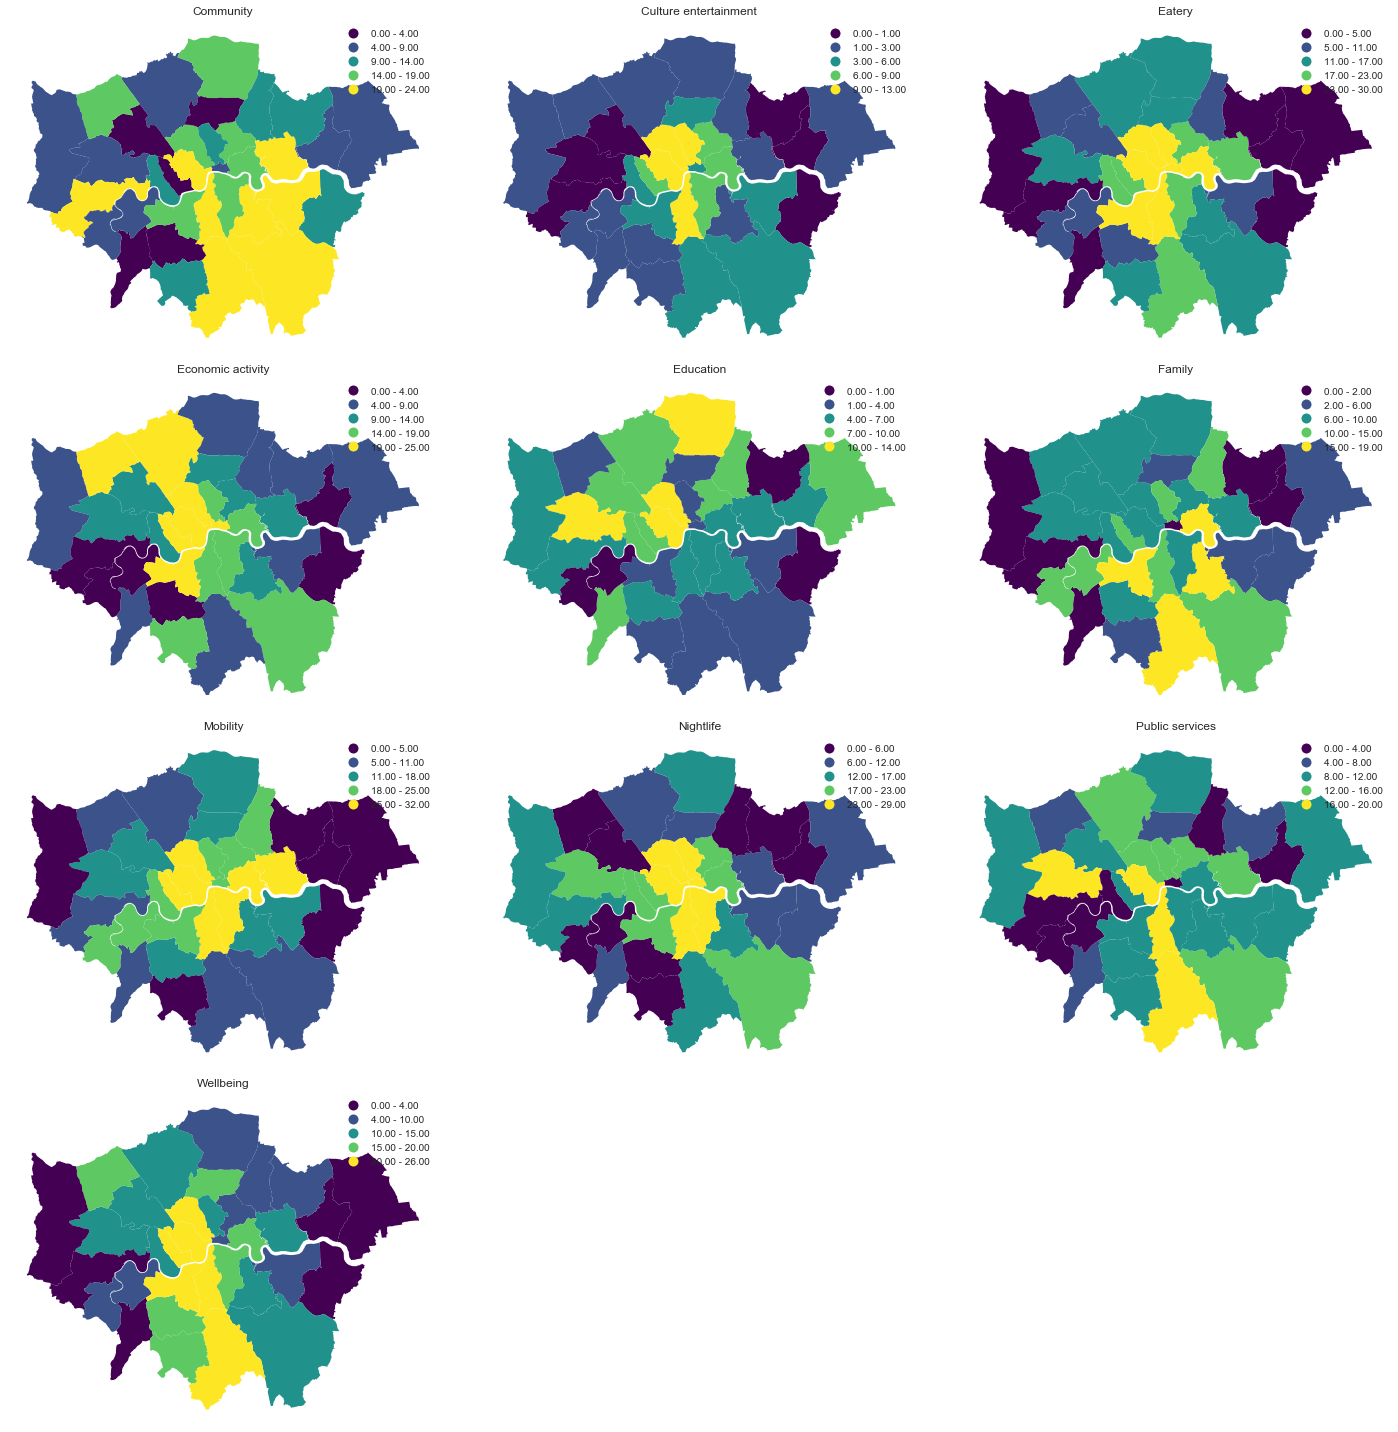

In [4]:
choropleth(gdf)

### Hexgrid

In [ ]:
# Merge pois with categories
pois = pd.merge(pois, pois_categories, left_on='amenity', right_on='pois')
pois.drop('amenity', axis=1, inplace=True)

# Remove amenities tagged 'misc'
pois = pois[pois['pois_category'] != 'misc']

In [105]:
# Polygons = boroughs
polygons = gdf[['geometry']].reset_index(drop=True)
polygons = polygons.to_crs(4326)

# Create a hexgrid
hex_res = 7
resolution = f'hex_id_{hex_res}'
buffer = 0.005
plot = False

hexgrid = create_hexgrid(polygons, hex_res=hex_res, buffer=buffer, plot=plot)
hexgrid.reset_index(drop=True, inplace=True)
hexgrid.crs = {'init': 'epsg:4326'}
# hexgrid.to_crs(3395).plot()
# plt.axis('off');

In [106]:
# Pois in hex?
pois_in_hex = gpd.sjoin(pois, hexgrid)
# pois_in_hex

# Create an empty column for counting
pois_in_hex['n'] = 1

# Pois in hex by category
pois_in_hex_by_cat = pois_in_hex.groupby(['pois_category', resolution]).sum()

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


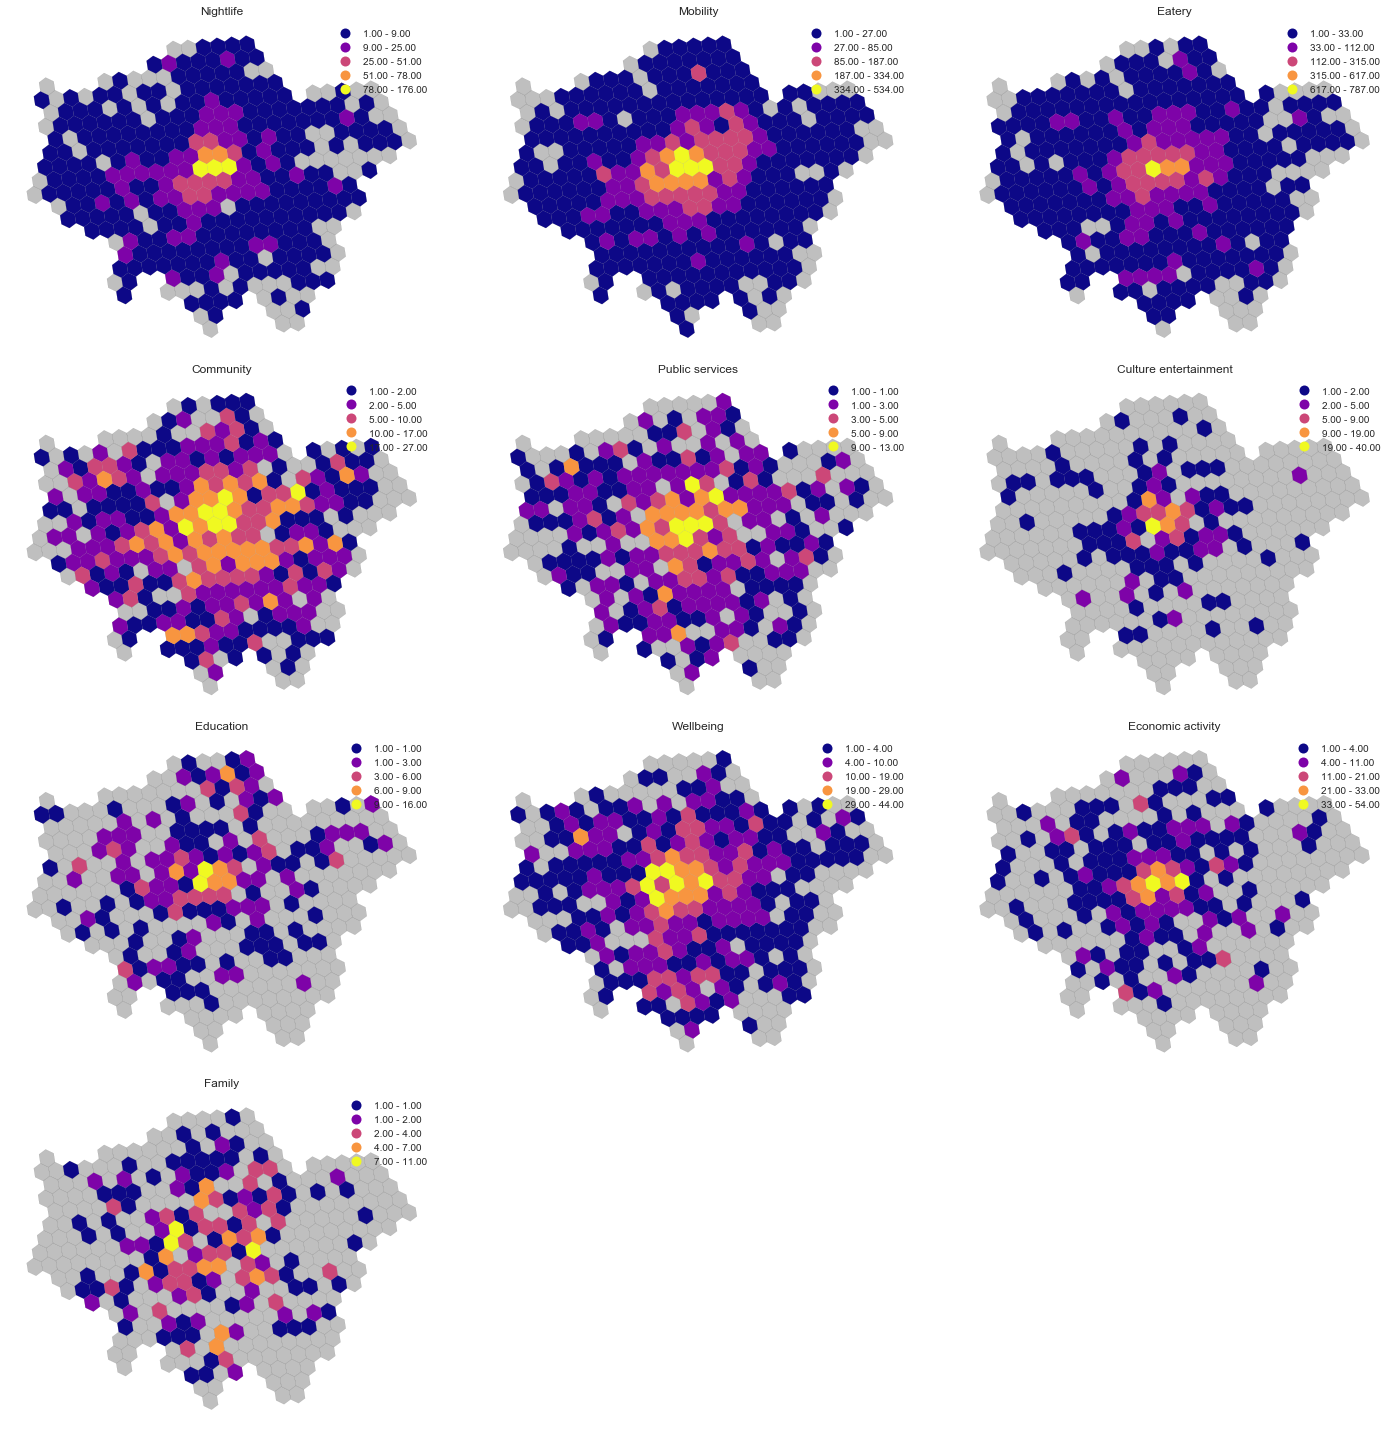

In [114]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
k = 0
columns = pois['pois_category'].unique().tolist()
for i in range(nrows):
    for j in range(ncols):
        merge = pd.merge(pois_in_hex_by_cat.loc[columns[k]], hexgrid, left_on=pois_in_hex_by_cat.loc[columns[k]].index, right_on=resolution)
        merge = gpd.GeoDataFrame(merge, geometry='geometry')
        merge.crs = {'init':'epsg:4326'}
        hexgrid.to_crs(epsg=3857).plot(color='gray', alpha=.5, ax=ax[i,j], linewidth=0.1, edgecolor='black')
        merge.to_crs(epsg=3857).plot(column='n', ax=ax[i, j], legend=True, scheme='fisher_jenks', cmap='plasma')
        # pois[pois['pois_category'] == columns[k]].to_crs(epsg=3857).plot(ax=ax[i, j], color='red') # visual check whether or not hexgrid "makes sense"
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}')
        ax[i, j].axis('off')
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()

### Voronoi tesselations

In [183]:
# Voronoi tesselations are constructed around points
# In our case these points are metro stations
stations = gpd.read_file('../data/external/geometry/metro_stations/stations_mod.shp')
stations.to_crs(epsg=27700, inplace=True)

# The resulting Voronoi tesselations will be cut by total Greater London boundary
border = gpd.read_file('../data/external/geometry/london_simplified/london.shp')
border.to_crs(epsg=27700, inplace=True)

In [184]:
# Define Voronoi
x = stations.geometry.x
y = stations.geometry.y
coords = list(zip(x, y))
voronoi = spatial.Voronoi(coords)

# Convert Voronoi cells to Shapely polygons
stations["cell"] = None
for i, idx_region in enumerate(voronoi.point_region):
    region = voronoi.regions[idx_region]
    cell_coords = [Point(voronoi.vertices[idx_point]) for idx_point in region]
    cell = Polygon([[p.x, p.y] for p in cell_coords])
    stations.loc[i, "cell"] = cell
    
# spatial.voronoi_plot_2d(voronoi, show_vertices=False, line_colors='orange', line_width=1, line_alpha=0.6, point_size=5)
# plt.axis("off");

total_bounds = border.total_bounds
total_bounds = box(total_bounds[0], total_bounds[1], total_bounds[2], total_bounds[3])
stations = stations.set_geometry("cell").loc[stations.set_geometry("cell").within(total_bounds)]
stations.to_crs(epsg=4326,inplace=True)
stations.crs = {'init': 'epsg:4326'}
stations['station_id'] = stations.index.tolist()
# stations.plot()
# plt.axis('off');

In [185]:
# Pois in voronoi?
pois_in_voronoi = gpd.sjoin(pois, stations)

# Create an empty column for counting
pois_in_voronoi['n'] = 1

# Pois in hex by category
pois_in_voronoi_by_cat = pois_in_voronoi.groupby(['pois_category', 'station_id']).sum()

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [176]:
# pois_in_voronoi_by_cat['community']

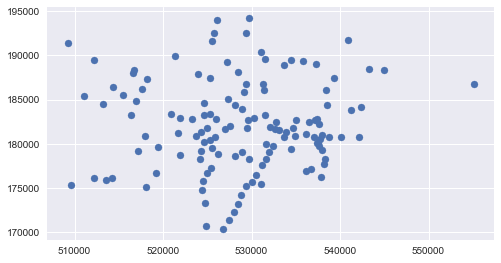

In [189]:
merge.plot()

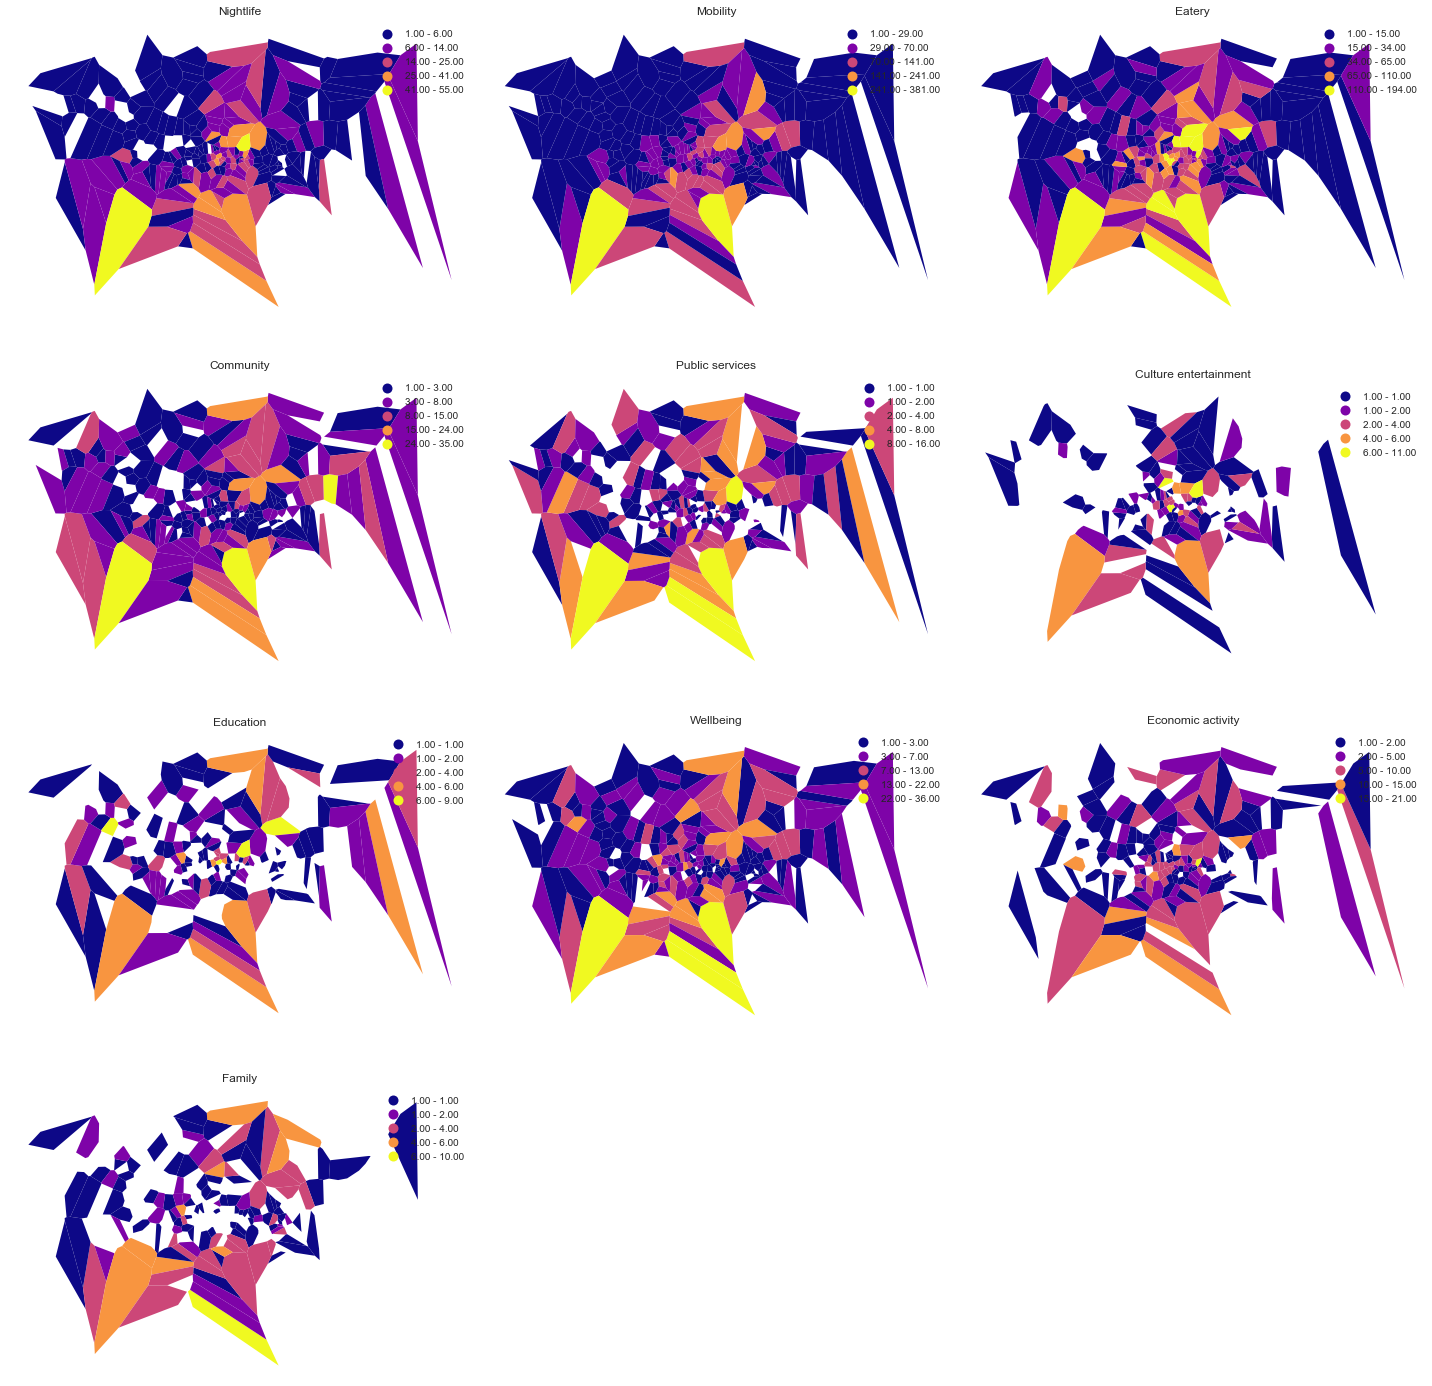

In [190]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
k = 0
columns = pois['pois_category'].unique().tolist()
for i in range(nrows):
    for j in range(ncols):
        merge = pd.merge(pois_in_voronoi_by_cat.loc[columns[k]], stations, left_on=pois_in_voronoi_by_cat.loc[columns[k]].index, right_on='station_id')
        merge = gpd.GeoDataFrame(merge, geometry='cell')
        merge.crs = {'init':'epsg:4326'}
        # hexgrid.to_crs(epsg=3857).plot(color='gray', alpha=.5, ax=ax[i,j], linewidth=0.1, edgecolor='black')
        merge.to_crs(epsg=3857).plot(column='n', ax=ax[i, j], legend=True, scheme='fisher_jenks', cmap='plasma')
        # pois[pois['pois_category'] == columns[k]].to_crs(epsg=3857).plot(ax=ax[i, j], color='red') # visual check whether or not hexgrid "makes sense"
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}')
        ax[i, j].axis('off')
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()

## 2. Amenities and traffic

In [38]:
stn_points = []
stations.to_crs(epsg=4326, inplace=True) # CRS should be EPSG=4326 when grabbing data from OSM
for geometry in stations["geometry"]:
    x, y = geometry.xy
    x = x[0]
    y = y[0]
    stn_points.append((y, x))
stations["stn_points"] = stn_points

In [81]:
entry = gpd.read_file('../spacetimegeo/data/processed/counts/entry_station.json')

In [82]:
entry.crs

{'init': 'epsg:4326'}

In [92]:
groupby = sjoin_pois.groupby(['pois_category', 'hex_id_8']).sum()

In [83]:
sjoin_entry = gpd.sjoin(entry[['total', 'geometry']], hexgrid)

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


<Figure size 576x396 with 0 Axes>

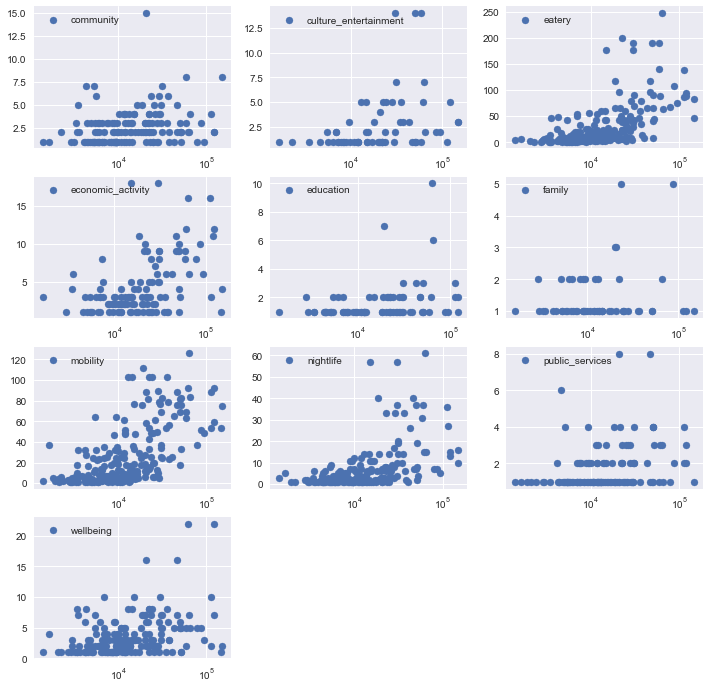

In [101]:
fig = plt.figure()
nrows = 4
ncols = 3
plt.figure(figsize=(12,12))
plot_num = 1
labels = {}
d = {}

for i in range(10):
    data = pd.merge(groupby.loc[columns[i]], hexgrid, left_on=groupby.loc[columns[i]].index, right_on='hex_id_8')
    data = pd.merge(data, sjoin_entry, left_on='hex_id_8', right_on='hex_id_8')
    plt.subplot(nrows, ncols, plot_num)
    plt.scatter(data['total'], data['n'], label=columns[i])
    plt.legend()
    # plt.yscale('log')
    plt.xscale('log')
    plot_num += 1

fig.legend(columns)

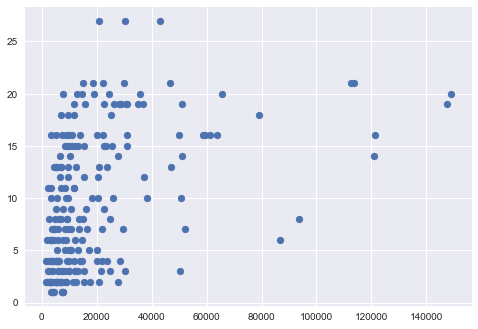

In [68]:
# hexgrid = tobler.area_weighted.area_interpolate(gdf.reset_index(drop=True).to_crs(epsg=4326), hexgrid, extensive_variables=columns.tolist(), allocate_total=True)
# hexgrid.crs = gdf.to_crs(epsg=4326).crs

#### Matching amenities data with station data

In [43]:
# match amenities to voronoi cells
amenities_voronois = gpd.sjoin(amenities[["name", "amenity", "LAD11NM", "geometry", "amenity_category"]],
                               station_vor[["station_name", "geometry", "cell"]], how="inner")

In [44]:
# get number of amenities for each amenity category
amenities_grouped = pd.DataFrame(amenities_voronois.groupby(["station_name", "amenity_category"]).agg(len)["amenity"])

In [45]:
# transform the data into more easily operationalizable format
records = pd.DataFrame(amenities_grouped.to_records())

In [46]:
amenity_categories = records['amenity_category'].unique()
print(amenity_categories.shape)

station_names = records['station_name'].unique()
print(station_names.shape)

(10,)
(276,)


In [47]:
# Generate new dataframe
columns = amenity_categories
index = station_names
data = pd.DataFrame(index=index, columns=columns)

In [48]:
# Fill the new dataframe
for index, row in data.iterrows():
    s = records[records['station_name'] == index][['amenity_category', 'amenity']]
    s.set_index('amenity_category', inplace=True)
    for i, r in s.iterrows():
        data.loc[index, i] = r['amenity']
data.fillna(0, inplace=True)

In [49]:
# # Combine station clusters with amenities and total counts
entry_station_cluster = entry_station_cluster[['station_name', 'total', 'label']]
entry_station_cluster.rename({'total' : 'total_counts'}, axis=1, inplace=True)

In [50]:
result = pd.merge(data, entry_station_cluster, left_on=data.index, right_on='station_name')

In [ ]:
# Total counts by amenity typoe

In [ ]:
# take a look at amenity frequency based on station cluster label
plt.figure(figsize=(8,6))
sns.scatterplot(x="eatery", y="total_counts", hue="label", data=result)
plt.yscale('log')

In [5]:
# relationships between amenity types?
# plt.figure(figsize=(10,8))
# sns.heatmap(result.iloc[:,:-3].corr(), annot=True)

In [6]:
# result.groupby('label').sum().iloc[:,:-1].plot.bar(figsize=(22,8))

In [54]:
data_i = data.reset_index()
X = data_i.iloc[:,1:]
y = data_i.iloc[:, 0]

In [55]:
# Get amenity compositions for each station
# Number of each amenity type as a fraction of total amenities within a station voronoi
X["total"] = X.sum(axis=1)
X_frac = X.iloc[:,:-1].div(X.total, axis=0)

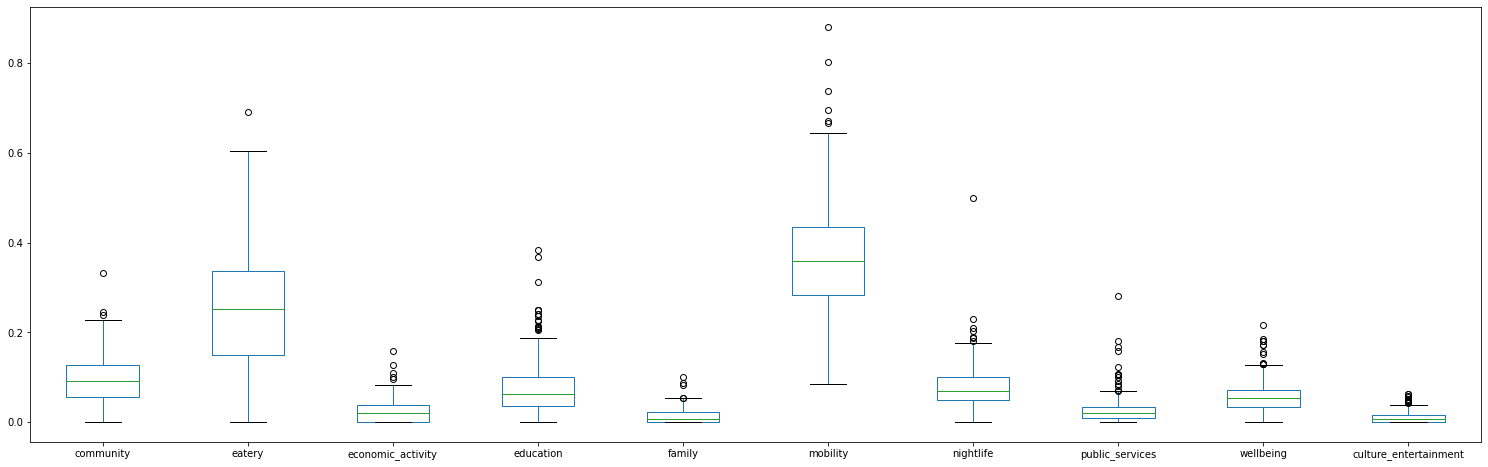

In [56]:
X_frac.plot.box(figsize=(26,8))

#### Clustering stations based on amenity composition

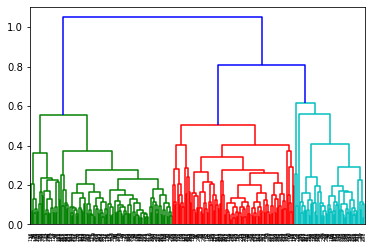

In [57]:
# dendrogram to get an idea of how many clusters
dend = shc.dendrogram(shc.linkage(X_frac, method='complete')) # "complete" for more compact clusters?

In [58]:
# define number of clusters and get labels
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
label = cluster.fit_predict(X_frac)

In [59]:
data['amenity_cluster'] = label

In [60]:
df = pd.merge(data, stations[['station_name', 'geometry']], left_on=data.index, right_on=stations['station_name'])

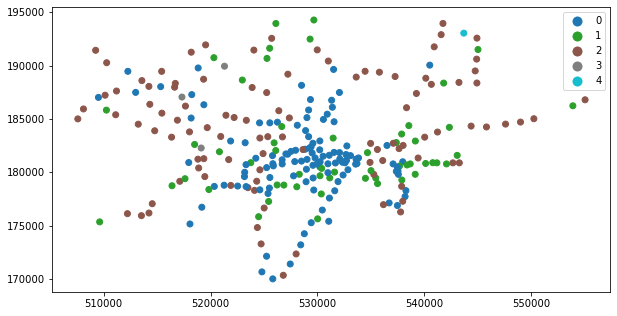

In [61]:
# review station types as categorized by amenity composition
gpd.GeoDataFrame(df, geometry=df['geometry']).plot(column='amenity_cluster', categorical=True, legend=True, figsize=(10,6))

#### Comparing stations - cluster labels from travel patterns + cluster labels from amenity composition

In [62]:
data.reset_index(inplace=True)
data.rename(columns={"index":"station_name"}, inplace=True)

In [63]:
data = data.merge(entry_station_cluster[["station_name", "label"]], on="station_name")

In [64]:
data = data.merge(stations[["station_name", "stn_points"]], on="station_name")

In [65]:
data.groupby(["label", "amenity_cluster"]).agg({"station_name":"count"}).reset_index().sort_values(["label", "station_name"], ascending=False)

,label,amenity_cluster,station_name
16,Potential feeder,0,29
18,Potential feeder,2,27
17,Potential feeder,1,12
19,Potential feeder,3,1
13,Polycenter,0,22
14,Polycenter,1,10
15,Polycenter,2,10
11,Outer residential,2,12
10,Outer residential,1,3
9,Outer residential,0,2


In [66]:
data["lat"] = [x[0] for x in data["stn_points"]]
data["lon"] = [x[1] for x in data["stn_points"]]

In [67]:
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon, data.lat))

In [68]:
# fig = px.scatter_mapbox(data, lat="lat", lon="lon", color="amenity_cluster", 
#                   hover_name = data.station_name, hover_data = data[["label", "amenity_cluster"]],
#                   zoom=9, mapbox_style="carto-positron")

# fig.show()

In [69]:
data.crs = {'init': 'epsg:4326'} # station date file is epsg=4326
data.to_crs(epsg=27700, inplace=True)

C:\Users\jryap\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



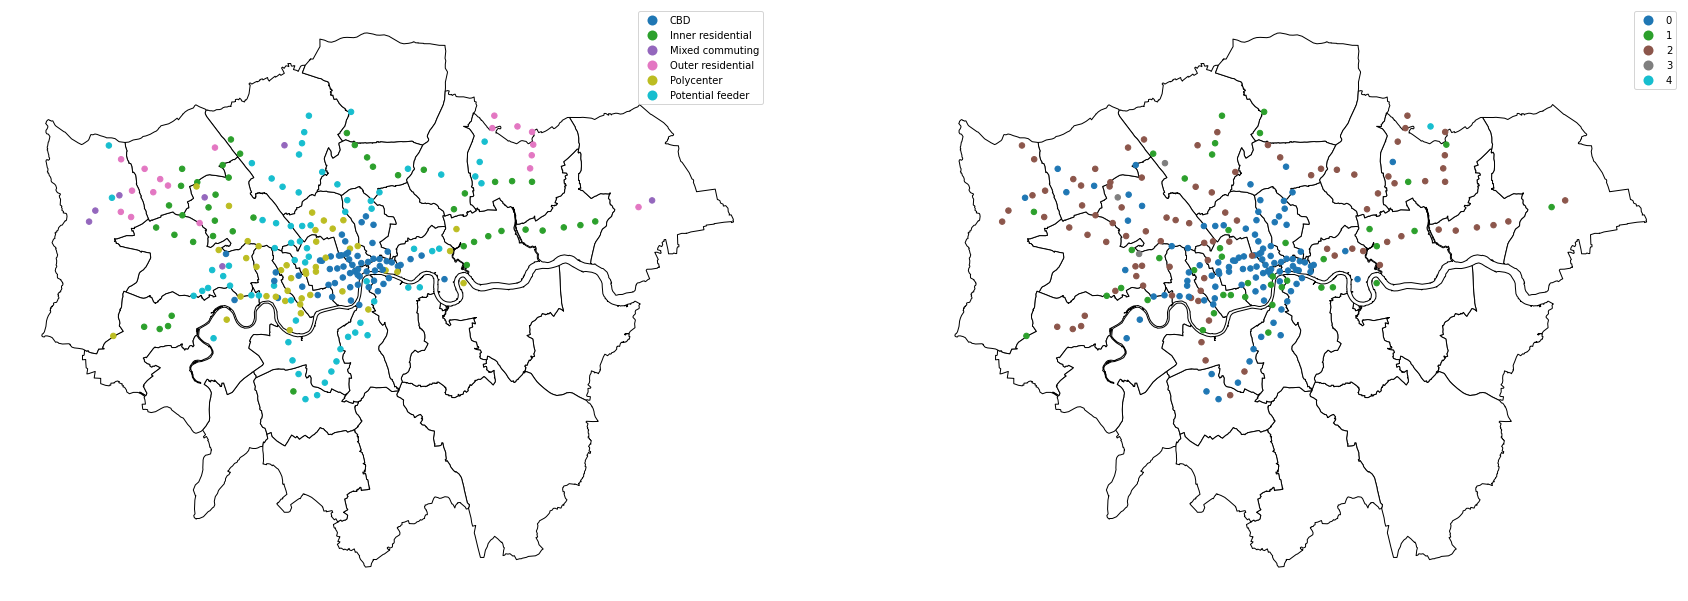

In [70]:
fig, ax = plt.subplots(figsize=(30,15), ncols=2) 

boroughs.plot(ax=ax[0],color='white', edgecolor='black')
boroughs.plot(ax=ax[1],color='white', edgecolor='black')

data.plot(ax=ax[0], column='label', categorical=True, legend=True, legend_kwds = {'bbox_to_anchor': (1, 1)},
                markersize=30)
data.plot(ax=ax[1], column='amenity_cluster', categorical=True, legend=True, legend_kwds = {'bbox_to_anchor': (1, 1)},
                markersize=30)
ax[0].axis('off')
ax[1].axis('off')

plt.show()
# plt.savefig('map.png')

#### ~Messing around

In [71]:
data["label_c"] = data.apply(lambda x : "CBD" if (x.label == "CBD") else ("Potential feeder" if (x.label=="Potential feeder") else ("Polycenter" if (x.label == "Polycenter") else ("Inner Resi" if (x.label == "Inner residential") else "Other"))), axis=1)

(500655.0638336639, 564875.8138502047, 153596.65686413186, 203187.7489867522)

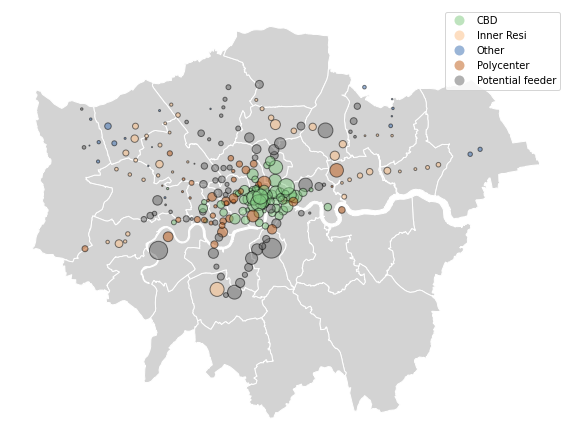

In [73]:
cat_of_interest = "eatery"

ax = boroughs.plot(color='lightgrey', edgecolor='white', figsize=(10,18))

data.plot(ax=ax, markersize=cat_of_interest, column=data['label_c'], cmap= "Accent", 
              edgecolor="black", alpha=.5, legend=True, legend_kwds = {'bbox_to_anchor': (1, 1)})

ax.axis('off')

## Conclusion

In [ ]:
Hypotheses to carry out
1. Choropleths to see distribution of amenity types?
2. Different distribution of amenities depending on population size (or density)?
3. Cluster stations based on amenities around?
4. Spatio-temporal cluster vs amenity cluster?
5. Regression analysis amenity cluster vs traffic at a certain time?

We used the following data sets
1. London Datastore (London shape files);
2. Office for National Statistics (London population);
3. Transport for London (metro traffic);
4. Wikimedia Commons (metro station locations);
5. OpenStreetMaps (points of interest).

Methods that we're planning to use
1. Hierarchical clustering?

Notebook overview

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%time
import datashader as ds, pandas as pd
import datashader.transfer_functions as tf

cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(pois, 'lat', 'lon')
img = tf.shade(agg, cmap=['lightblue', 'darkblue'], how='log')
img